In [32]:
import pandas as pd
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("../stock_historical_data/{}.csv".format("LT.NS"))
df.set_index("Date", inplace=True)
df["date"] = df.index

In [4]:
new_df = pd.DataFrame(df.Close)
new_df.reset_index(inplace=True)

In [5]:
new_df = new_df.drop("Date",axis=1)

In [6]:
new_df

,Close
0,1212.869873
1,1245.600220
2,1236.109985
3,1219.166016
4,1222.638184
...,...
905,2717.600098
906,2688.149902
907,2638.399902
908,2695.350098


In [7]:
#scaling fream
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [8]:
##splitting dataset into train and test split
training_size = int(len(new_df)*0.8)
test_size     = len(new_df) - training_size
train_data,test_data = new_df[0:training_size,:],new_df[training_size:len(new_df),:1]

In [9]:
new_df.shape,train_data.shape,test_data.shape

((910, 1), (728, 1), (182, 1))

In [10]:
train_data.shape , test_data.shape

((728, 1), (182, 1))

In [11]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[(i+time_step)+1][0])

    return numpy.array(dataX), numpy.array(dataY)

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest    = create_dataset(test_data, time_step)

In [13]:
X_train.shape,y_train.shape,X_test.shape,ytest.shape

((627, 100), (627,), (81, 100), (81,))

In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
X_test.shape

(81, 100, 1)

In [16]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

2023-08-30 17:56:35.433655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=2,batch_size=64,verbose=1)

Epoch 1/2
10/10 [==============================] - 10s 344ms/step - loss: 0.0702 - val_loss: 0.0118
Epoch 2/2
10/10 [==============================] - 2s 160ms/step - loss: 0.0098 - val_loss: 0.0446


In [21]:
import tensorflow as tf

In [22]:
### Lets Do the prediction and check performance metrics
train_predict =  model.predict(X_train)
test_predict  =  model.predict(X_test)

3/3 [==============================] - 0s 38ms/step


In [23]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)

In [24]:
test_predict

array([[1937.2294],
       [1940.6997],
       [1944.583 ],
       [1948.7588],
       [1953.1338],
       [1957.577 ],
       [1961.599 ],
       [1964.8484],
       [1967.2316],
       [1968.6848],
       [1969.2112],
       [1968.7838],
       [1967.4701],
       [1965.4695],
       [1962.9095],
       [1959.8882],
       [1956.5785],
       [1953.1708],
       [1949.8271],
       [1946.6184],
       [1943.5782],
       [1940.7384],
       [1938.2028],
       [1936.1323],
       [1934.6307],
       [1933.8447],
       [1933.8884],
       [1934.8383],
       [1936.589 ],
       [1939.0487],
       [1942.0917],
       [1945.5958],
       [1949.4471],
       [1953.5237],
       [1957.7584],
       [1962.1106],
       [1966.588 ],
       [1971.0753],
       [1975.4397],
       [1979.6163],
       [1983.555 ],
       [1987.4893],
       [1991.4684],
       [1995.521 ],
       [1999.6592],
       [2003.9121],
       [2008.1426],
       [2012.2124],
       [2016.134 ],
       [2019.8417],


In [25]:
train_predict.shape,test_predict.shape
result = np.concatenate((train_predict, test_predict), axis=0)
result.shape,train_predict.shape

((708, 1), (627, 1))

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1490.3271586301373

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

2009.1332549009828

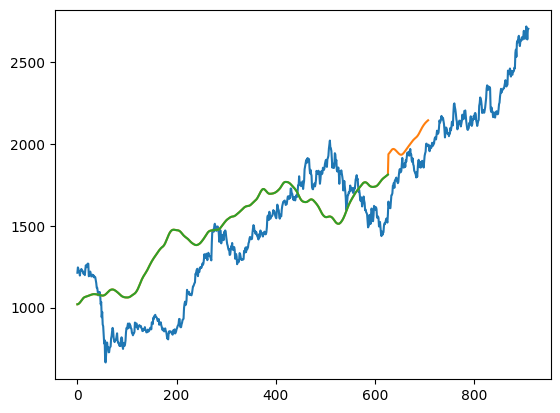

In [33]:
### Plotting 
# shift train predictions for plotting
look_back=100
#trainPredictPlot = numpy.empty_like(df1)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
#testPredictPlot = numpy.empty_like(df1)
#testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(new_df))
plt.plot(result)
plt.plot(train_predict)
plt.show()

In [31]:
new_df.shape,trainPredictPlot.shape,testPredictPlot.shape

NameError: name 'trainPredictPlot' is not defined